# Kmeans: Iris data vs Algorithm clusters

by Joe Ganser

<a href="https://github.com/JoeGanser/teaching/blob/main/Lectures/unsupervised_learning/kmeans/KMeans.ipynb">Github notebook link</a>

In this notebook, we'll be fitting the kmeans algorithm to the iris data set, using standard metric procedures, and see how the fit compares to the natural clusters of the Iris dataset. Below is a scatter plot of the data points and the clusters, as compared from various axes.

In [40]:
from sklearn import datasets

# import some data to play with
X = datasets.load_iris(as_frame=True)['data']
X['cluster'] = datasets.load_iris(as_frame=True)['target']
#X.head()
X

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),cluster
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


![iris_plots.png](iris_plots.png)

### Example 1: Fit different  & measure K values

* Put the dataframe into `StandardScaler()` format
* Use a for loop to test values of `k` in `range(2,40)`
* At each iteration, fit `KMeans` and evaluate for `k`
    * Measure the sum of squared errors (aka 'Inertia')
    * Measure the silhouette coefficient for the clusters
    * Save each measure to a dictionary
* Print the dictionary into dataframe format

In [79]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.drop('cluster',axis=1))
scores = {'sse':[],'silhouette':[]}

for k in range(2,40):
    model = KMeans(n_clusters=k,max_iter=100)
    model.fit(X_scaled)
    
    silhouette = silhouette_score(X_scaled,model.labels_,metric='euclidean')
    scores['sse'].append(model.inertia_)
    scores['silhouette'].append(silhouette)
pd.DataFrame(scores).head()

,sse,silhouette
0,222.361705,0.581750
1,139.825435,0.459378
2,114.304803,0.388220
3,90.807283,0.341947
4,80.022188,0.322037


### Example 2: Visualize the K means performance

Plot the `SSE` and `Silhouette` scores as a function of `K` using scatter plots. This will allow us to detect the 'elbow' to select the appropriate value of `K` for `Kmeans`.

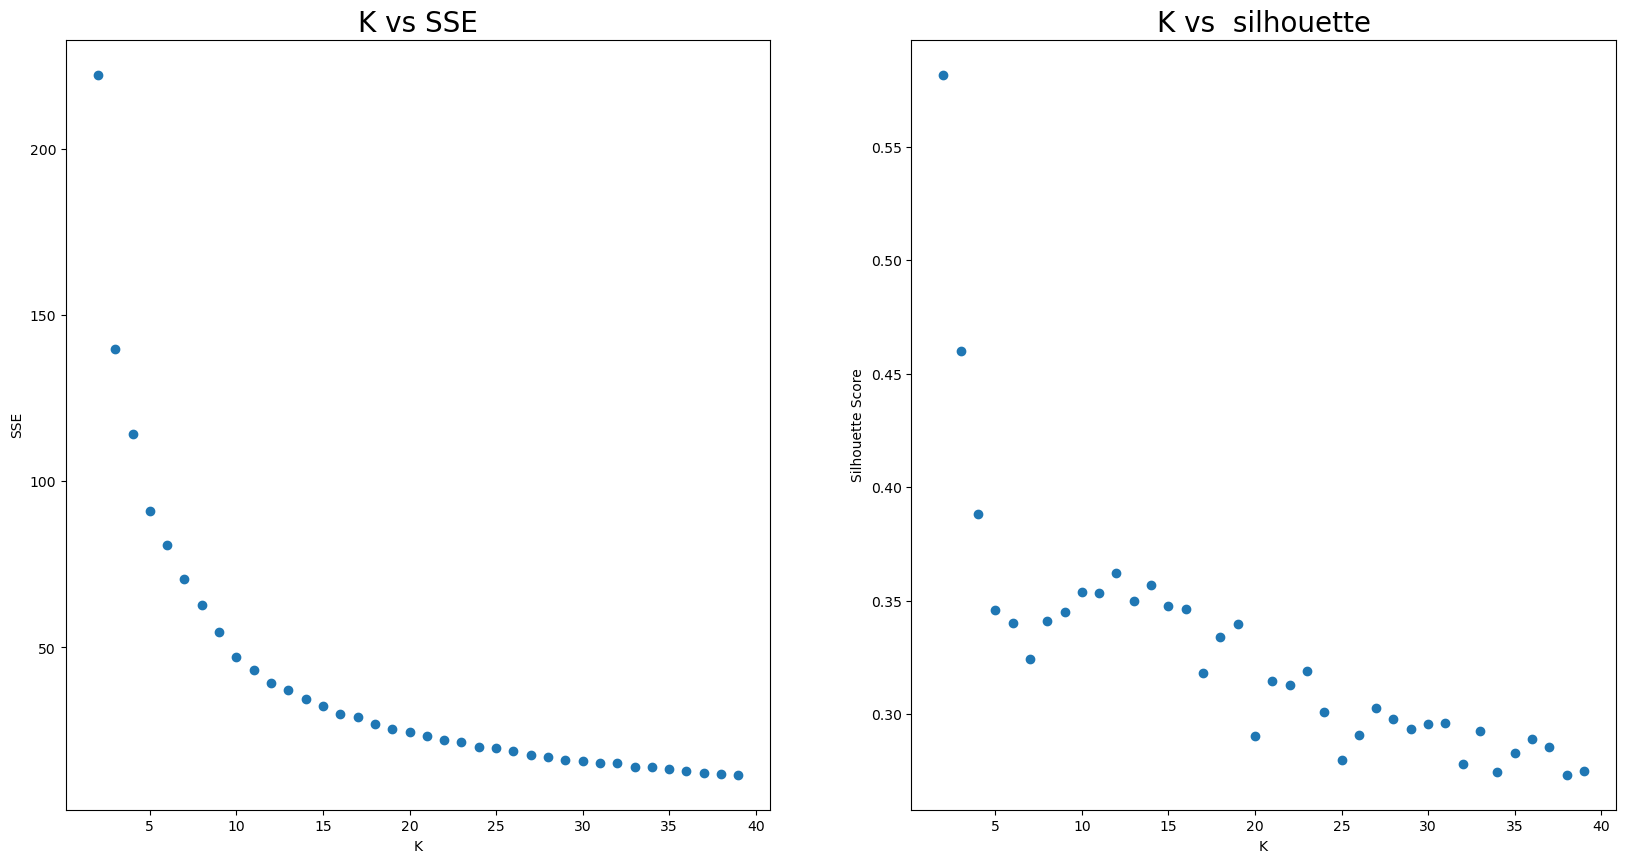

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.scatter(range(2,40),scores['sse'])
plt.title('K vs SSE',fontsize=20)
plt.xlabel('K')
plt.ylabel('SSE')

plt.subplot(1,2,2)
plt.scatter(range(2,40),scores['silhouette'])
plt.title('K vs  silhouette',fontsize=20)
plt.ylabel('Silhouette Score')
plt.xlabel('K')
plt.show()

### Example 3: Use `KneeLocator` package to find `K`

Using the `kneed` package, find the optimal value of `k` from the sum of squared errors and silhouette scores. Then, using the plots from example 2 above, make a vertical bar with location of the optimal values of `k` for each metric.

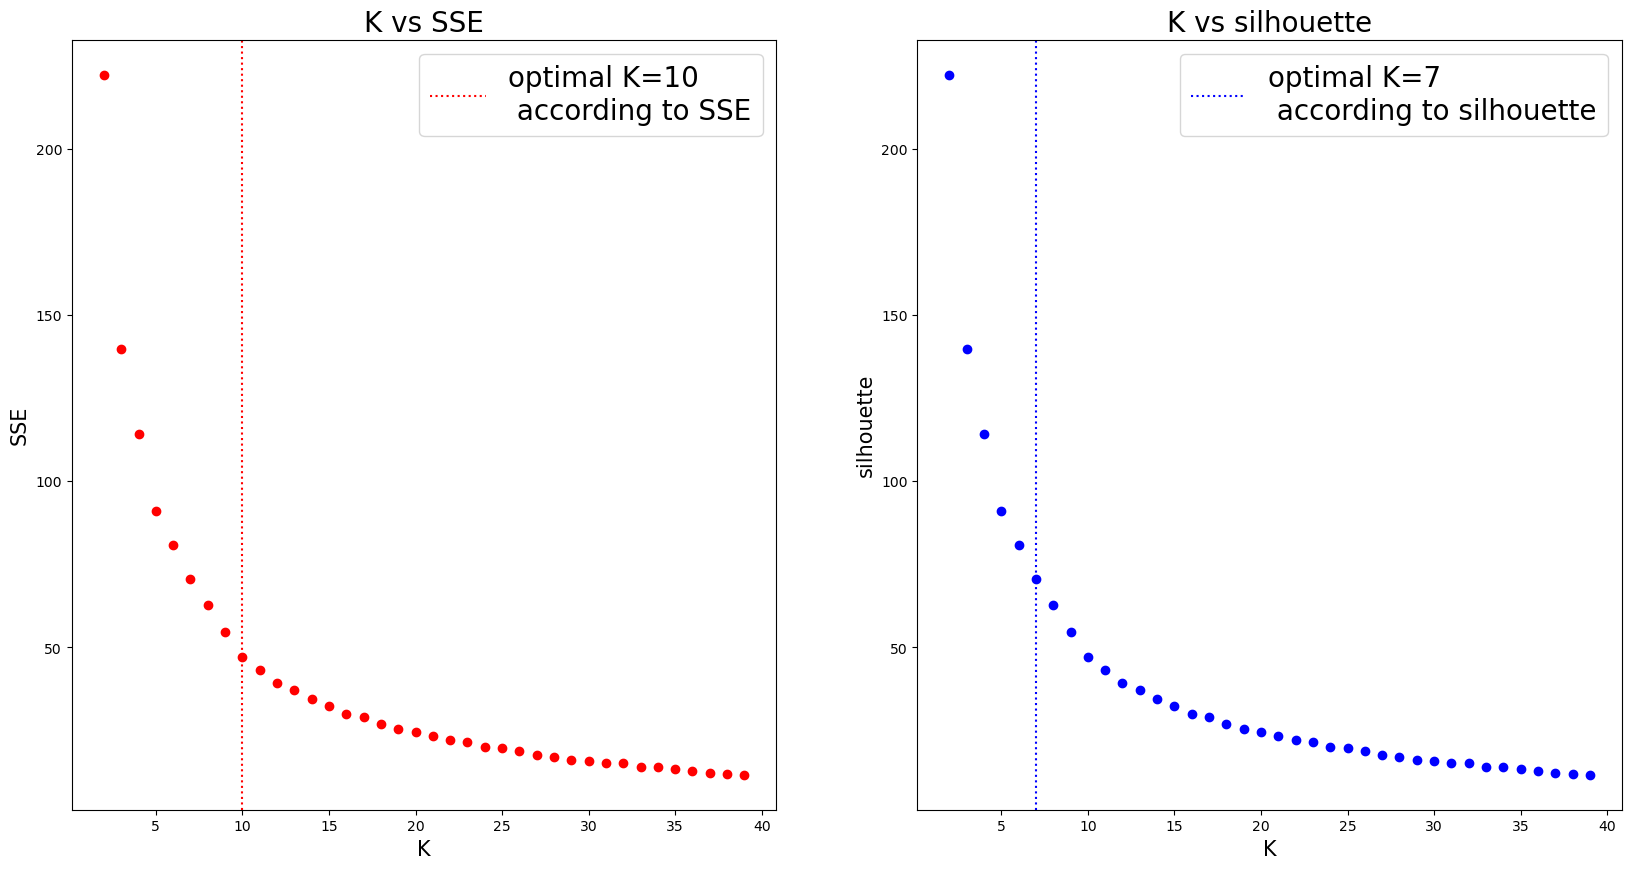

In [29]:
from kneed import KneeLocator

k_values = range(2,40)
knee_sse = KneeLocator(k_values,scores['sse'],curve='convex',direction='decreasing')
optimal_k_sse = knee_sse.knee


plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.scatter(range(2,40),scores['sse'],c='r')
plt.axvline(optimal_k_sse,
            label='optimal K={} \n according to SSE'.format(optimal_k_sse),
            c='r',linestyle=':')
plt.title('K vs SSE',fontsize=20)
plt.xlabel('K',fontsize=15)
plt.ylabel('SSE',fontsize=15)
plt.legend(fontsize=20)


knee_silh = KneeLocator(k_values,scores['silhouette'],curve='convex',direction='decreasing')
optimal_k_silh = knee_silh.knee


plt.subplot(1,2,2)
plt.scatter(range(2,40),scores['sse'],c='b')
sse = round(scores['sse'][optimal_k_silh],3)
plt.axvline(optimal_k_silh,
            label='optimal K={} \n according to silhouette'.format(optimal_k_silh),
            c='b',linestyle=':')
plt.title('K vs silhouette',fontsize=20)
plt.xlabel('K',fontsize=15)
plt.ylabel('silhouette',fontsize=15)
plt.legend(fontsize=20)
plt.show()

### Example 4: Silhouette plot for each cluster

It's known that their are three natural seperate clusters in the Iris dataset, and each of these clusters will have their own silhouette score. Vertically plot these silhouette scores and compare them to the overall silhouette score.

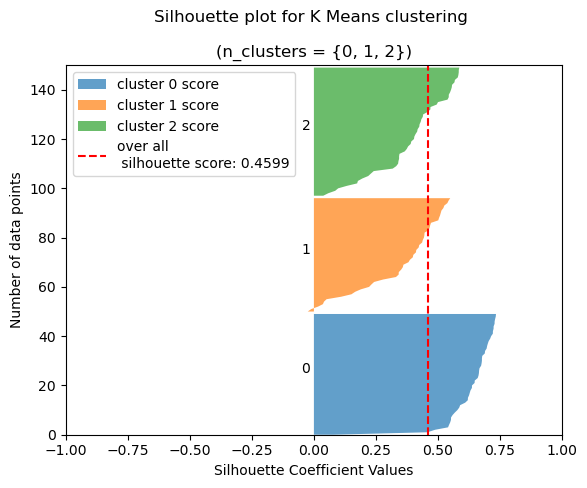

In [18]:
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np

optimal_k = min(optimal_k_sse,optimal_k_silh,3)
model = KMeans(n_clusters=optimal_k,max_iter=100)
model.fit(X_scaled)
df = pd.DataFrame(X_scaled)
df['cluster'] = model.labels_
# Get the silhouette score for the entire dataset
silhouette = silhouette_score(df[df.columns[:-1]],df['cluster'],metric='euclidean')
silhouette_scores = silhouette_samples(df[df.columns[:-1]],df['cluster'],metric='euclidean')

# Plot the silhouette scores for each cluster
fig, ax = plt.subplots()
ax.set_xlim([-1, 1])
ax.set_ylim([0, len(X)])

y_lower = 0
for i in range(optimal_k):
    cluster_silhouette_scores = silhouette_scores[model.labels_ == i]
    cluster_silhouette_scores.sort()
    size_cluster_i = cluster_silhouette_scores.shape[0]
    y_upper = y_lower + size_cluster_i
    if i<4:
        label = 'cluster {} score'.format(i)
    else:
        label = None
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_scores,
                      alpha=0.7, edgecolor='none',label=label)
    if i<8:
        s = str(i)
    else:
        s = '.'
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, s)
    y_lower = y_upper

ax.set_title('''Silhouette plot for K Means clustering 
             \n(n_clusters = {})'''.format(set(model.labels_)))
ax.set_xlabel("Silhouette Coefficient Values")
ax.set_ylabel("Number of data points")

ax.axvline(x=silhouette, color="red", linestyle="--",
           label='over all \n silhouette score: {}'.format(round(silhouette,4)))
plt.legend(loc='upper left')
plt.show()

### Example 5: Cluster centers

Using the model for `k=3`, find the cluster centers.

In [28]:
clusters = pd.DataFrame(model.cluster_centers_)
clusters = pd.DataFrame(scaler.inverse_transform(clusters),columns=X.columns[:-1])
clusters

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.006000,3.428000,1.462000,0.246000
1,6.780851,3.095745,5.510638,1.972340
2,5.801887,2.673585,4.369811,1.413208


### Example 6: Scatter plot the Kmeans clusters

Using the model built for `k=3`, make scatter plot for each axes to show what K means predicts as the clusters.

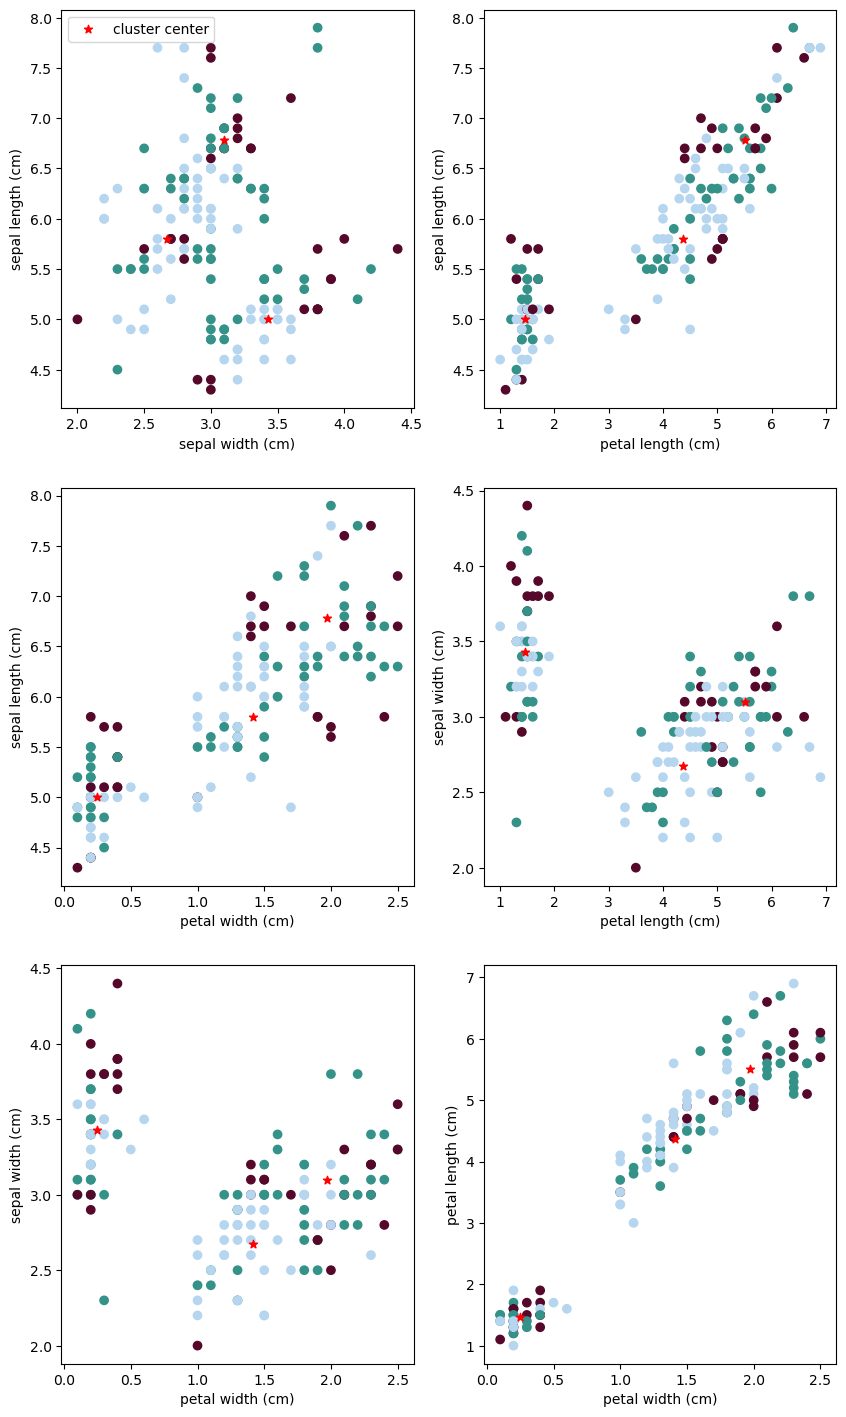

In [80]:
import matplotlib.pyplot as plt
n=1
plt.figure(figsize=(10,30))
from itertools import combinations
from matplotlib.colors import ListedColormap
v=3
X['cluster'] = model.labels_
num_range = range(1, optimal_k + 1)
color_range = np.random.rand(3, 3)

z_range = range(0, optimal_k+1)
num_colors = len(z_range)
color_range = np.random.rand(num_colors, 3)[:3]
# Create a colormap that maps each z value to a unique color
cmap = ListedColormap(color_range)
v=2
n=1
for c in list(combinations(X.columns[:-1],2)):
    plt.subplot(len(combinations_list)//v,v,n)
    # Create the scatter plot
    x = X[c[1]]
    y = X[c[0]]
    z = X['cluster']
    plt.scatter(x, y, c=z, cmap=cmap)
    # Add a colorbar to the plot
    plt.scatter(x=clusters[c[1]],y=clusters[c[0]],marker='*',label='cluster center',c='r')
    if n==1:
        plt.legend()
    plt.ylabel(c[0])
    plt.xlabel(c[1])
    n+=1
plt.show()

### Example 7: What's the discrepency?

Comparing the plots shown at the beginning and the plots predicted by the algorithm shows the imperfect nature of Kmeans. Kmeans, by its nature, is a fundamentally random algorithm - picking random positions and adjusting the position until metrics are minimized. We can see in example 4 that we can get relatively good clusters according to the silhouette scores, however these dont necessarily match what occurs in nature (example 6). It's important to be aware that the random nature of Kmeans can make large discrpencies between naturally occurring clusters and the ones predicted by the algorithm.